In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('gray')
plt.rcParams['figure.figsize'] = (12,9)

import pandas as pd
import numpy as np
from src import utils

## Loading data
Lets load the [USA baby name census data](https://www.ssa.gov/OACT/babynames/limits.html) from 1880 - present as `.csv`. Each year is split into an individual file, so it's best to load them one by one and then join them together as a nice long dataframe, which we'll manipulate afterwards.

In [2]:
df_dict = {year: pd.read_csv('data/raw/yob{}.txt'.format(year),
                             names=['Name', 'Sex', 'Count']) 
           for year in range(1880, 2017)}

lets add the year to each of our yearly dataframes so that they're identifiable after being merged

In [3]:
for year in df_dict: 
    df_dict[year]['Year'] = year

and now concatenate them together so that they're in the long dataframe format we need to get started.

In [4]:
df = pd.concat([df_dict[i] for i in df_dict], axis=0)

df.sample(15)

,Name,Sex,Count,Year
17454,Camren,M,32,1990
7601,Royden,M,16,1919
6371,Fulton,M,24,1934
29408,Antavis,M,5,2003
356,Floy,F,73,1901
14271,Anarosa,F,5,1998
8104,Briell,F,12,2000
18966,Dionta,M,21,1993
28918,Lydia,M,7,2005
514,Ava,F,184,1920


## Exploring Data
Let's now split our data into male and female groups for simplicity. Names appear in both genders and the statistics get complicated when you're dealing with duplicates.

In [5]:
df_males   = df[df['Sex'] == 'M']
df_females = df[df['Sex'] == 'F']

We can now plot the number of girls born each year, for example, quite easily.

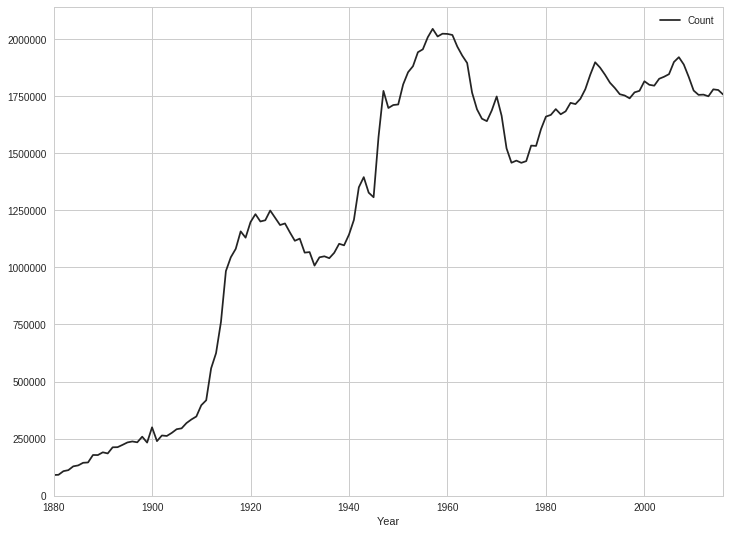

In [6]:
(df_females
 .groupby('Year')
 .sum()
 .plot()
 .set_ylim(0,));

It would be good to have this data in pivot table form - indexing pivoted data is usually much faster and makes the queries much more pythonic

In [7]:
male_pivot   = df_males.pivot_table(columns='Name', index='Year', values='Count')
female_pivot = df_females.pivot_table(columns='Name', index='Year', values='Count')

Let's see what that looks like

In [8]:
(male_pivot
 .sample(10, axis=0)
 .sample(10, axis=1))

Name,Patrickjohn,Neo,Gillie,Courtnee,Wellman,Kadir,Keyaun,Trevore,Issey,Coe
Year,,,,,,,,,,
1886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,103.0,NaN,NaN,NaN,10.0,7.0,NaN,5.0,5.0
1936,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,64.0,NaN,NaN,NaN,14.0,6.0,NaN,NaN,NaN
1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2003,NaN,84.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0


We can now plot the incidence of a particular name (mine in this example) through US history very easily.

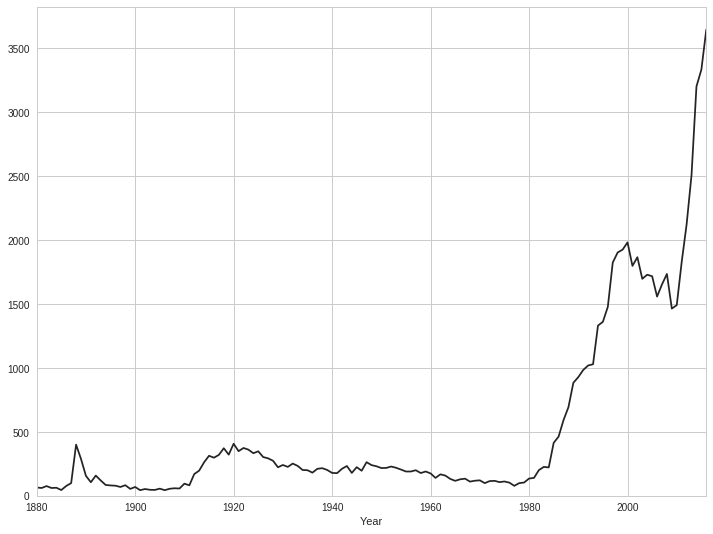

In [9]:
male_pivot['Harrison'].plot().set_ylim(0,);

Lets see exactly how people in the US share my name, gender and birth-year.

In [10]:
male_pivot['Harrison'][1993]

1029.0

## Probabilities
Now we can move onto the real interesting stuff. We want to infer the probability of being a certain age, given a certain name, so our aim _mathematically_ is to calculate $P_{S}(\mathrm{age=A})$ (effectively the proportion of a given subpopulation $S$ with age $A$) for each age in our distribution. To do this, we can use the following formula

$$ P_{S}(\mathrm{age=A}) = \sum_{N}\ P_{S}(\mathrm{name})\ P(\mathrm{age=A\ |\ name = N}) $$

where $P_{S}(\mathrm{name})$ is the probability of having a particular name within the subpopulation $S$, and $P(\mathrm{age=A\ |\ name = N})$ is the probability of having the age in question given a particular name, for the entire population. We sum the product of these two values for every name we have a record for, and return the probability of a member of our subpopulation having a particular age.

It's relatively easy to calculate the required values. Instead of calculating each one fresh when it's needed, it makes sense to precompute the values and just look them up each time we need a new age distribution.  
The probability of having a name given a particular birth-year is calculated by dividing each cell in our pivot table by the sum of the values in each year.  
The reverse is true for the probability of having a certain name given a birth year - we divide each cell by the sum of the values for each name.

In [11]:
male_prob_name_given_year   = male_pivot.div(male_pivot.sum(axis=1), axis=0)
female_prob_name_given_year = female_pivot.div(female_pivot.sum(axis=1), axis=0)

male_prob_year_given_name   = male_pivot.div(male_pivot.sum(axis=0), axis=1)
female_prob_year_given_name = female_pivot.div(female_pivot.sum(axis=0), axis=1)

These values apply to our entire population, so can be left as a static lookup table. They look very similar to the pivot table shown previously - the only difference is that the numbers now show probabilities instead of raw counts.

In [12]:
(male_prob_name_given_year
 .sample(10, axis=0)
 .sample(10, axis=1))

Name,Kirklen,Daisean,Aqil,Kannan,Avyay,Yadriel,Johnnie,Marquese,Bobb,Shawntae
Year,,,,,,,,,,
1899,NaN,NaN,NaN,NaN,NaN,NaN,0.001422,NaN,NaN,NaN
1974,NaN,NaN,NaN,NaN,NaN,NaN,0.000359,0.000004,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN,0.000264,0.000007,NaN,NaN
1928,NaN,NaN,NaN,NaN,NaN,NaN,0.001687,NaN,NaN,NaN
2013,NaN,0.000003,NaN,0.000004,0.000005,0.000008,0.000061,0.000010,NaN,NaN
1884,NaN,NaN,NaN,NaN,NaN,NaN,0.000402,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,0.000173,0.000015,NaN,NaN
1964,NaN,NaN,NaN,NaN,NaN,NaN,0.000465,NaN,NaN,NaN
1961,NaN,NaN,NaN,NaN,NaN,NaN,0.000497,NaN,NaN,NaN


We now need to create a series with the distribution of names within our subpopulation.

Our aim now is to calculate $P_{S}(\mathrm{age=A})$ (effectively the proportion of a given subpopulation $S$ with age $A$) for each age in our distribution. To do this, we can use the following formula

$$ P_{S}(\mathrm{age=A}) = \sum_{N}\ P_{S}(\mathrm{name})\ P(\mathrm{age=A\ |\ name = N}) $$

where $P_{S}(\mathrm{name})$ is the probability of having a particular name within our subpopulation $S$, and $P(\mathrm{age=A\ |\ name = N})$ is the probability of having the age in question given a particular name, for the entire population. 

In [13]:
def get_year_distribution(population_prob_year_given_name, subpopulation_names):
    intersection = np.intersect1d(subpopulation_names, 
                                  population_prob_year_given_name.columns.values)

    sub_names_intersect = [n for n in subpopulation_names if n in intersection]
    
    sub_prob_name = pd.Series(sub_names_intersect).value_counts(normalize=True) 
    
    start_year = population_prob_year_given_name.index.min()
    end_year = population_prob_year_given_name.index.max()
    
    probabilities = {year: ((sub_prob_name.loc[intersection] * 
                             population_prob_year_given_name[intersection].loc[year])
                            .sum()) 
                     for year in range(start_year, end_year + 1)}
    
    return pd.Series(probabilities)

# A Practical example with US Legislators
The use for this in industrial settings is pretty obvious, and the code that I've written out above _does_ work nicely, but it's hard to come up with a sufficiently long list of associated names to illustrate this principle effectively. I've settled on US legislators because 
- their data is publicly available
- they're _definitely_ US citizens (which is necessary as our original data here is based on US births)
- there's a (relatively) large group of them (though not nearly as large as I'd like)
- they're easily split into male and female.

In [14]:
df = pd.read_csv('https://theunitedstates.io/congress-legislators/legislators-current.csv')
df['birthday'] = pd.to_datetime(df['birthday'], format='%Y-%m-%d')

df.sample(5)

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
207,Meeks,Gregory,1953-09-25,M,rep,NY,5.0,Democrat,https://meeks.house.gov,2234 Rayburn HOB; Washington DC 20515-3205,...,1506.0,N00001171,NaN,53469.0,400271,4360.0,NaN,NaN,29776.0,Gregory Meeks
38,Aderholt,Robert,1965-07-22,M,rep,AL,4.0,Republican,https://aderholt.house.gov,235 Cannon HOB; Washington DC 20515-0104,...,1460.0,N00003028,NaN,45516.0,400004,441.0,Robert B. Aderholt,NaN,29701.0,Robert Aderholt
60,Burgess,Michael,1950-12-23,M,rep,TX,26.0,Republican,https://burgess.house.gov,2336 Rayburn HOB; Washington DC 20515-4326,...,1751.0,N00025219,NaN,1003620.0,400052,50120.0,NaN,NaN,20355.0,Michael C. Burgess
225,Pearce,Stevan,1947-08-24,M,rep,NM,2.0,Republican,https://pearce.house.gov,2432 Rayburn HOB; Washington DC 20515-3102,...,1738.0,N00012672,NaN,12063.0,400313,10655.0,Steve Pearce,NaN,20337.0,Steve Pearce (politician)
67,Carter,John,1941-11-06,M,rep,TX,31.0,Republican,https://carter.house.gov,2110 Rayburn HOB; Washington DC 20515-4331,...,1752.0,N00025095,NaN,1004257.0,400068,49296.0,John Carter,NaN,20356.0,John Carter (Texas politician)


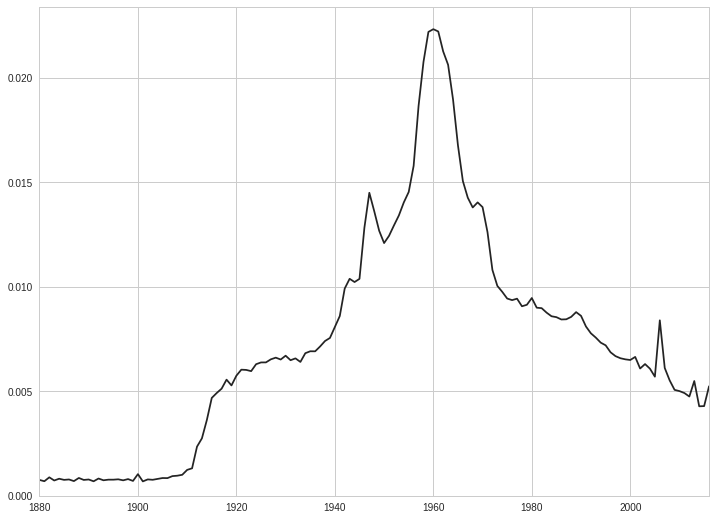

In [15]:
male_legistalor_names = df[df['gender'] == 'M']['first_name'].apply(utils.name_cleaner).values

result = get_year_distribution(male_prob_year_given_name, male_legistalor_names)
result.plot().set_ylim(0,);

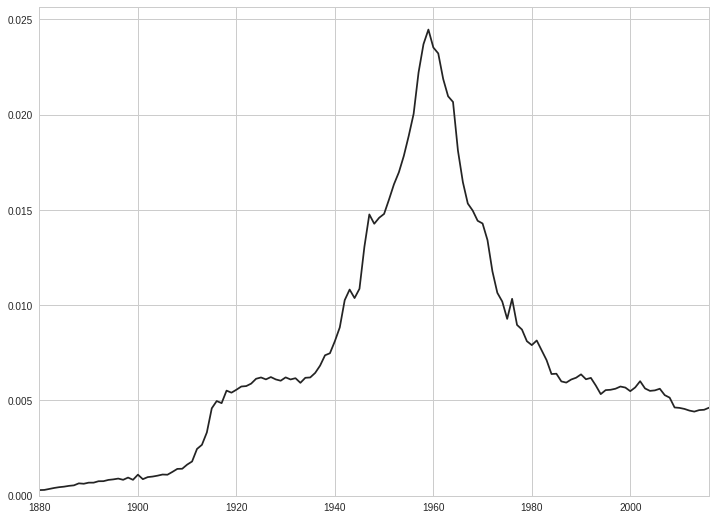

In [16]:
female_legistalor_names = df[df['gender'] == 'F']['first_name'].apply(utils.name_cleaner)

result = get_year_distribution(female_prob_year_given_name, female_legistalor_names)
result.plot().set_ylim(0,);

We can plot the true distribution of birth years to see how we've done...

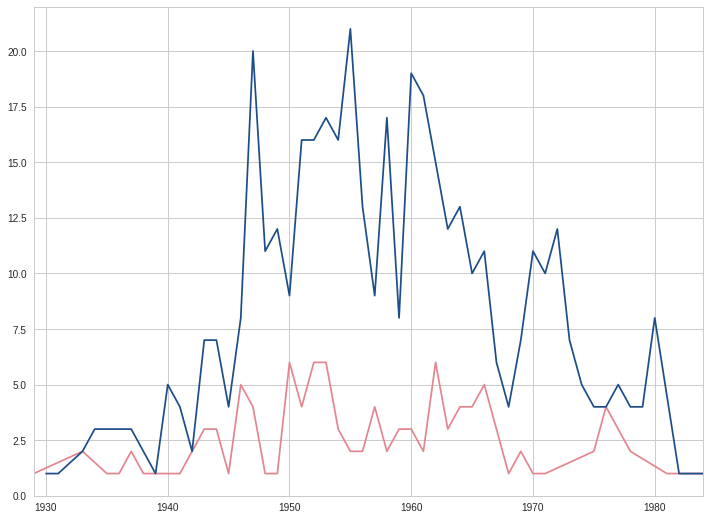

In [17]:
gender_colour_dict = {'M': '#1d4e89',
                      'F': '#e38690'}

for gender, group in df.groupby('gender'):
    (group['birthday'].dt.year
     .value_counts()
     .sort_index()
     .plot(c=gender_colour_dict[gender]))

Not amazingly well to be honest, but we are working with a pretty small sample size (only 538 total names) as illustrated by the spikiness of that graph. Ideally I'd like a to apply this to a list of names on the order of 10<sup>4</sup> or 10<sup>5</sup>.  
It works fine in practical situations, I promise...